In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov
import nmf.bayes

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms


from theory.represent import rescale_WH

from read_data.reading import read_face_images, images_matrix_grid,\
                                roll_images, unroll_images 

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                                              compare_performance, plot_performance_dict,\
                                              torch_algo_wrapper

In [3]:
image_data = read_face_images("data/att_faces/images").astype(float)

<IPython.core.display.Javascript object>


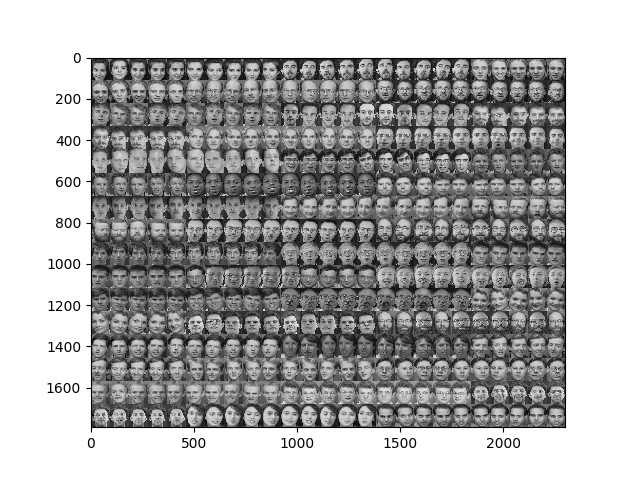

In [4]:
grid = images_matrix_grid(image_data, (16, 25))
plt.imshow(grid, cmap="gray")

In [5]:
unrolled_image_data, ori_shape = unroll_images(image_data)

In [6]:
unrolled_image_data.shape

(400, 10304)

In [7]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [8]:
errors_result = errors_at_time_t_over_inner_dim(unrolled_image_data, range(5, 360, 20),
                             30, {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

NameError: name 'errors_at_time_t_over_inner_dim' is not defined

In [ ]:
f, ax = plt.subplots()
plot_dict(errors_result, ax, log=False)

In [ ]:
shape = unrolled_image_data.shape
inner_dims = [2, 25, 50, 100, 150, 200]
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

performances = {}
for inner_dim in inner_dims:
    performance = compare_performance(unrolled_image_data, 
                                      inner_dim, time_limit=100,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)
    performances[inner_dim] = performance

In [ ]:
for inner_dim in inner_dims:
    f, ax = plt.subplots()
    ax.set_title("inner_dim = {}".format(inner_dim))
    performance = performances[inner_dim]
    plot_performance(performance, ax)

In [11]:
shape = unrolled_image_data.shape
W_init = np.random.rand(shape[0], inner_dim)
H_init = np.random.rand(inner_dim, shape[1])

inner_dim = 25
errors = compare_performance(unrolled_image_data, 
                                      inner_dim, time_limit=100,
                                      W_init=W_init, H_init=H_init, 
                                      algo_dict_to_test=algo_dict_to_test)

In [ ]:
f, ax = plt.subplots()
plot_ratios_cpu_gpu(performances[25], ax)
f, ax = plt.subplots()
plot_ratios_cpu_algo(performances[25], ax)
f, ax = plt.subplots()
plot_ratios_gpu_algo(performances[25], ax)

In [ ]:
nesterov = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, device="cuda")
W, H = nesterov(V=unrolled_image_data, inner_dim=25, time_limit=40, max_steps=np.inf)

In [32]:
W, H = rescale_WH(W, H)

<IPython.core.display.Javascript object>


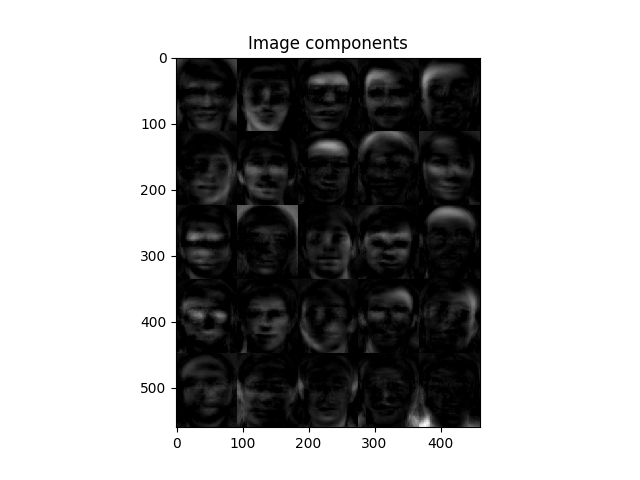

Text(0.5, 1.0, 'Image components')

In [33]:
image_components = roll_images(H, ori_shape)
grid = images_matrix_grid(image_components, (5, 5))
f, ax = plt.subplots()
ax.imshow(grid, cmap="gray")
ax.set_title("Image components")

<IPython.core.display.Javascript object>


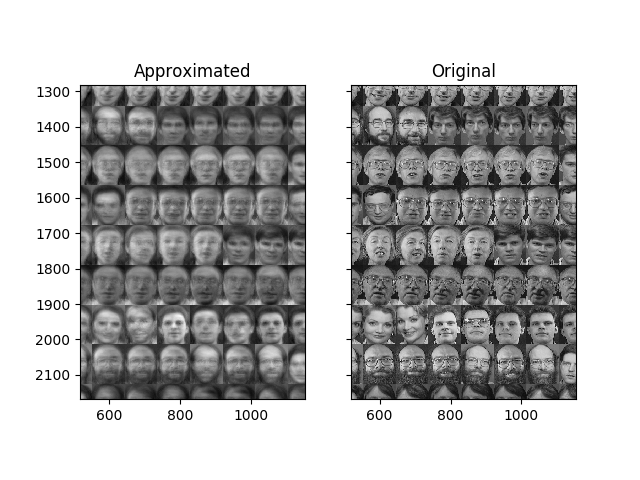

Text(0.5, 1.0, 'Original')

In [30]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharex=True, sharey=True)

approx_unrolled_image_data = W @ H
approx_image_data = roll_images(approx_unrolled_image_data, ori_shape)
grid = images_matrix_grid(approx_image_data, (25, 16))
ax1.imshow(grid, cmap="gray"); ax1.set_title("Approximated")
grid = images_matrix_grid(image_data, (25, 16))
ax2.imshow(grid, cmap="gray"); ax2.set_title("Original")

In [27]:
W, H, errors_t = torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm)(
                        V=unrolled_image_data,
                        inner_dim=25, 
                        max_steps=8000,
                        time_limit=5,
                        record_errors=True)

In [21]:
W, H, errors = nmf.bayes.factorise_ICM(unrolled_image_data, 25, 
                                       max_steps=80000, time_limit=60, record_errors=True)

<IPython.core.display.Javascript object>


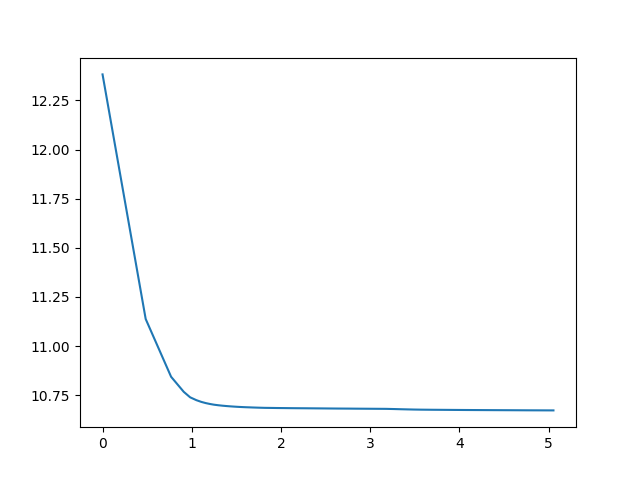

In [29]:
plt.plot(errors_t[:, 0], np.log(errors_t[:, 1]))
